In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
data_dir = '/kaggle/input/cidaut-ai-fake-scene-classification-2024/Train'
csv_path = '/kaggle/input/cidaut-ai-fake-scene-classification-2024/train.csv'

df = pd.read_csv(csv_path)
images = []
labels = []

In [3]:
for index, row in df.iterrows():
    image_file = row['image']  
    label = row['label']      
    image_path = os.path.join(data_dir, image_file)
    if os.path.exists(image_path):
        # Open and convert image to grayscale for SIFT
        image = Image.open(image_path).convert("L")
        image_array = np.array(image)
        images.append(image_array)
        labels.append(label)

images_np = np.array(images)
labels_np = np.array(labels)

In [4]:
def extract_sift_features(images):
    sift = cv2.SIFT_create()
    feature_list = []
    for img in images:
        keypoints, descriptors = sift.detectAndCompute(img, None)
        if descriptors is not None:
            feature_list.append(np.mean(descriptors, axis=0))
        else:
            feature_list.append(np.zeros((128,)))
    return np.array(feature_list)

sift_features = extract_sift_features(images_np)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(sift_features, labels_np, test_size=0.2, random_state=42)

svc = SVC(kernel="linear", probability=True, random_state=42)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
y_pred_prob = svc.predict_proba(X_test)[:, 1]  


Classification Report:
              precision    recall  f1-score   support

        Fake       0.75      0.67      0.71        67
        Real       0.74      0.81      0.77        77

    accuracy                           0.74       144
   macro avg       0.74      0.74      0.74       144
weighted avg       0.74      0.74      0.74       144

AUC-ROC Score: 0.8137


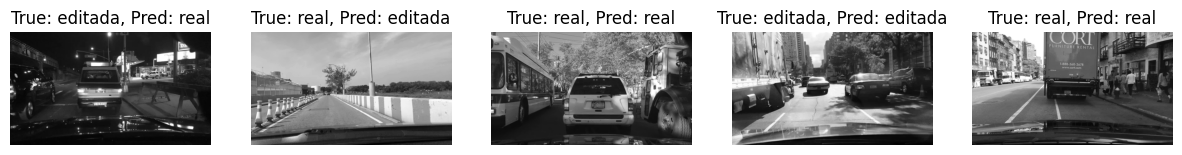

Class Distribution:
Class editada: 315 images
Class real: 405 images


In [6]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Fake", "Real"]))

auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC-ROC Score: {auc_score:.4f}")

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    ax = axes[i]
    ax.imshow(images_np[i], cmap="gray")
    ax.set_title(f"True: {labels_np[i]}, Pred: {y_pred[i]}")
    ax.axis("off")
plt.show()

label_counts = Counter(labels_np)
print("Class Distribution:")
for label, count in label_counts.items():
    print(f"Class {label}: {count} images")

In [9]:
import joblib

joblib.dump(svc, 'trained_svc_model.pkl')

['trained_svc_model.pkl']

In [19]:
import os
import numpy as np
import cv2
from PIL import Image

test_dir = '/kaggle/input/cidaut-ai-fake-scene-classification-2024/Test'

test_images = []
image_filenames = []

for image_file in os.listdir(test_dir):
    if image_file.endswith(('.jpg', '.jpeg', '.png')):  # Check for valid image formats
        image_path = os.path.join(test_dir, image_file)
        if os.path.exists(image_path):
            # Open and convert image to grayscale for SIFT
            image = Image.open(image_path).convert("L")
            image_array = np.array(image)
            test_images.append(image_array)
            image_filenames.append(image_file)

test_images_np = np.array(test_images)

def extract_sift_features(images):
    sift = cv2.SIFT_create()
    feature_list = []
    for img in images:
        keypoints, descriptors = sift.detectAndCompute(img, None)
        if descriptors is not None:
            feature_list.append(np.mean(descriptors, axis=0))
        else:
            feature_list.append(np.zeros((128,)))
    return np.array(feature_list)

test_sift_features = extract_sift_features(test_images_np)

print("SIFT features shape:", test_sift_features.shape)


SIFT features shape: (180, 128)
